# Import libraries

In [1]:
#!pip install lightgbm
#!pip install pactools
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Javascript
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay, \
confusion_matrix, PrecisionRecallDisplay, precision_recall_curve, classification_report

### Define Generalization function

In [2]:
def gen_score(x,y):
    return np.abs(((x - y) / y) * 100)

# Reading in pickle files

In [3]:
# Balanced data set after SMOTE
X_train = pd.read_pickle('./datasets/Z_train.pickle')
y_train = pd.read_pickle('./datasets/y_train.pickle')
X_test = pd.read_pickle('./datasets/Z_test.pickle')
y_test = pd.read_pickle('./datasets/y_test.pickle')
train = pd.read_csv('./datasets/train.csv')
#Z_train_feat_eng = pd.read_pickle('./ML_data/Z_train_feat_eng.pickle')
#Z_test_feat_eng = pd.read_pickle('./ML_data/Z_test_feat_eng.pickle')

In [4]:
print(f"X_train's shape is {X_train.shape}")
print(f"y_train's shape is {y_train.shape}")
print(f"X_test's shape is {X_test.shape}")
print(f"y_test's shape is {y_test.shape}")

X_train's shape is (15822, 232)
y_train's shape is (15822,)
X_test's shape is (2089, 232)
y_test's shape is (2089,)


In [5]:
# Checking the proportion in y_train, y_test data
print('The proportion of data in y_train is','\n', pd.DataFrame(y_train.value_counts(normalize=True)))
print('The proportion of data in y_test is','\n', pd.DataFrame(y_test.value_counts(normalize=True)))

The proportion of data in y_train is 
    WnvPresent
0         0.5
1         0.5
The proportion of data in y_test is 
    WnvPresent
0    0.947343
1    0.052657


# LGBM Model Training

In [6]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_train_pred = lgbm.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.968524838832006

In [7]:
y_test_pred = lgbm.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9248444231689804

In [8]:
gen_score = gen_score(accuracy_score(y_test, y_test_pred), accuracy_score(y_train, y_train_pred))
print(f"The generalization score is {gen_score}")

The generalization score is 4.509994365833928


In [13]:
y_test_pred = lgbm.predict_proba(X_test)[:,1]

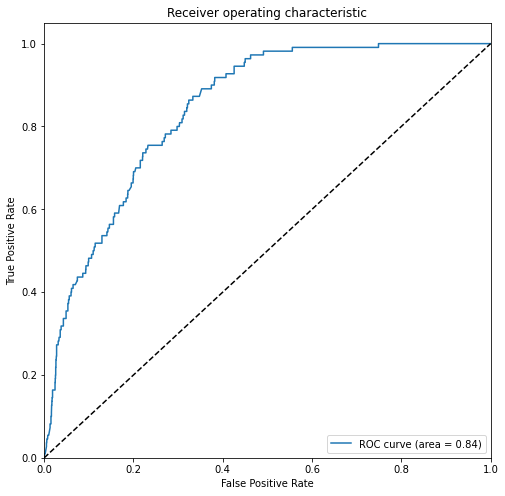

In [14]:
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

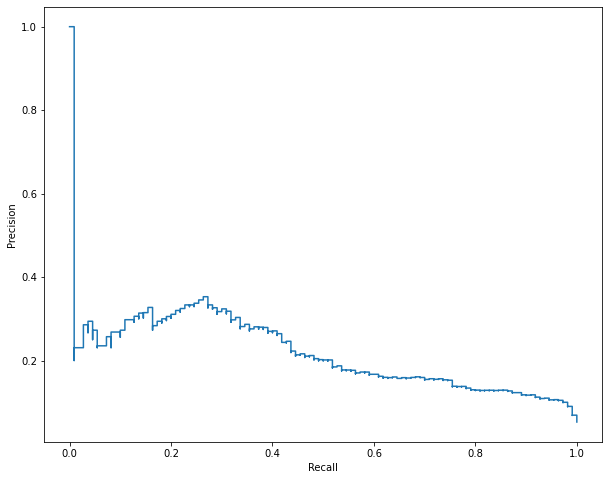

In [15]:
fig, ax = plt.subplots(figsize=(10,8))

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
disp = PrecisionRecallDisplay(precision, recall)
disp.plot(ax=ax);

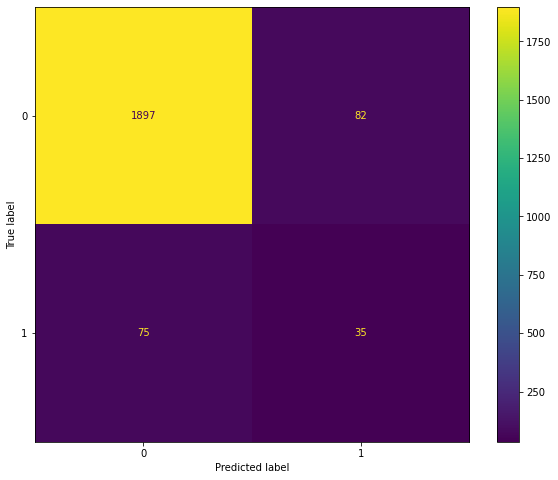

In [17]:
y_test_pred = lgbm.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
cmp = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(10,8))
cmp.plot(ax=ax);

In [18]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1979
           1       0.30      0.32      0.31       110

    accuracy                           0.92      2089
   macro avg       0.63      0.64      0.63      2089
weighted avg       0.93      0.92      0.93      2089



# LGBM (Hyperparameter Tuning)

In [19]:
lgb_estimator = LGBMClassifier(objective='binary', learning_rate=0.01, )
param_grid = {
    'num_leaves': [5,10,15,20,25,30,35,45,50],
    'reg_alpha': [0.1,0.2,0.3,0.4, 0.5,0.6],
    'n_estimators': [100,200,300,400,500],
    'max_depth': [5,10,15,20,25,30,35,45,50],
    }

gs = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, n_jobs=-1)
lgbm_gs = gs.fit(X_train, y_train)

In [20]:
lgbm_gs.best_params_

{'max_depth': 35, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 0.3}

In [21]:
#with open('./ML_data/lgbm_gs.pkl', 'wb') as f:
#    pickle.dump(lgbm_gs, f)

In [22]:
#with open ('./ML_data/lgbm_gs.pkl', 'rb') as f:
#    lgbm_gs = pickle.load(f)

In [23]:
y_test_pred = lgbm_gs.predict(X_test)

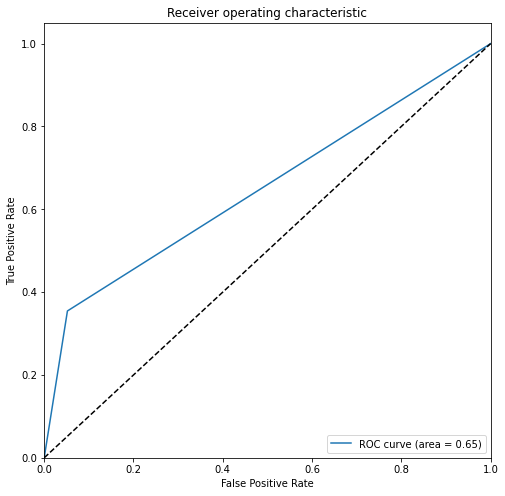

In [24]:
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [25]:
df = pd.concat([pd.DataFrame(train.columns), pd.DataFrame(lgbm_gs.best_estimator_.feature_importances_)], \
          axis=1)
df.columns = ['Feature', 'Importance']
df.sort_values(by='Importance', ascending=False, inplace=True)
df = df.head(10)
df

,Feature,Importance
29,Longitude,966
32,spp_pipiens,867
26,TS,758
28,Latitude,711
27,VC,641
31,spp_erraticus,637
171,T238,616
158,T224,590
1,Day,546
38,T001,533


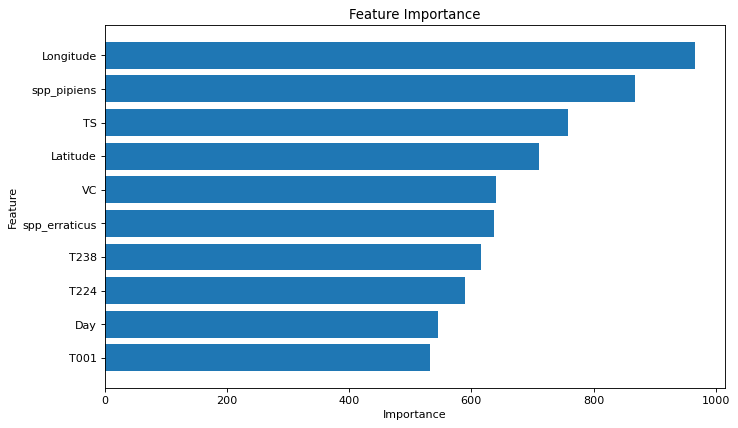

In [26]:
plt.figure(figsize=(10, 6), dpi=80)
plt.barh(df['Feature'], df['Importance'])
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.gca().invert_yaxis();

# Converting Month, Day to Categorical

In [85]:
train.head()

,Month,Day,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,...,T218B,T065A,T002A,T200A,T002B,T090C,T090B,T234,T128A,spray
0,5,29,1,88,60,74,58,65,0.0,29.39,...,0,0,0,0,0,0,0,0,0,0
1,5,29,2,88,65,77,59,66,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0
2,5,29,2,88,65,77,59,66,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0
3,5,29,2,88,65,77,59,66,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0
4,5,29,2,88,65,77,59,66,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0


In [86]:
train[['Month', 'Day']] = train[['Month', 'Day']].astype(str)
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 188 columns):
 #    Column           Dtype  
---   ------           -----  
 0    Month            object 
 1    Day              object 
 2    Station          int64  
 3    Tmax             int64  
 4    Tmin             int64  
 5    Tavg             int64  
 6    DewPoint         int64  
 7    WetBulb          int64  
 8    PrecipTotal      float64
 9    StnPressure      float64
 10   SeaLevel         float64
 11   ResultSpeed      float64
 12   ResultDir        int64  
 13   AvgSpeed         float64
 14   BC               int64  
 15   BR               int64  
 16   DZ               int64  
 17   FG               int64  
 18   FU               int64  
 19   GR               int64  
 20   HZ               int64  
 21   M                int64  
 22   MI               int64  
 23   RA               int64  
 24   SN               int64  
 25   SQ               int64  
 26   TS              

In [87]:
train = pd.concat([pd.get_dummies(train[['Month', 'Day']]), train.drop(['Month', 'Day'], axis=1)], axis=1)
train.head()

,Month_10,Month_5,Month_6,Month_7,Month_8,Month_9,Day_1,Day_10,Day_11,Day_12,...,T218B,T065A,T002A,T200A,T002B,T090C,T090B,T234,T128A,spray
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Define X, Y

In [88]:
X = train.drop('spray', axis=1)
y = train['spray']

# Checking Data Imbalance

In [89]:
y.value_counts(normalize=True)

0    0.894646
1    0.105354
Name: spray, dtype: float64

# Train, Test Split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# SMOTE Training Data

In [91]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

# Normalizing

In [92]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

# LGBM (Hyperparameter Tuning)

In [93]:
lgb_estimator = LGBMClassifier(objective='binary', learning_rate=0.01, )
param_grid = {
    'num_leaves': [5,10,15,20,25,30,35,45,50],
    'reg_alpha': [0.1,0.2,0.3,0.4, 0.5,0.6],
    'n_estimators': [100,200,300,400,500],
    'max_depth': [5,10,15,20,25,30,35,45,50],
    }

gs = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, n_jobs=-1)
lgbm_gs_train = gs.fit(X_train, y_train)

In [94]:
lgbm_gs_train.best_params_

{'max_depth': 25, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 0.2}

In [95]:
with open('./ML_data/lgbm_gs_train.pkl', 'wb') as f:
    pickle.dump(lgbm_gs_train, f)

In [10]:
with open ('./ML_data/lgbm_gs_train.pkl', 'rb') as f:
    lgbm_gs_train = pickle.load(f)

In [100]:
y_test_pred = lgbm_gs_train.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

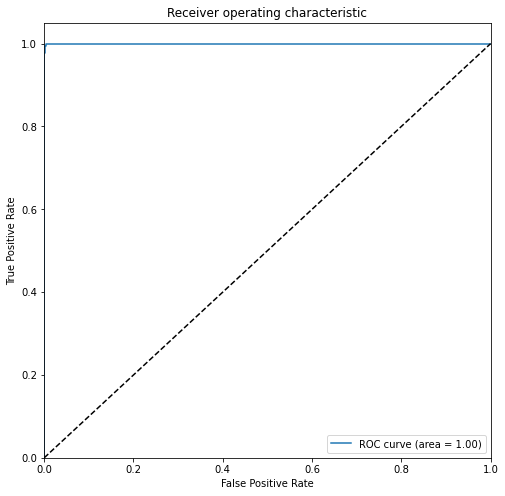

In [98]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [7]:
with open ('./assets/feature.pickle', 'rb') as f:
    feature = pickle.load(f)

In [11]:
df = pd.concat([pd.DataFrame(feature), pd.DataFrame(lgbm_gs_train.best_estimator_.feature_importances_)], \
          axis=1)
df.columns = ['Feature', 'Importance']
df.sort_values(by='Importance', ascending=False, inplace=True)
df = df.head(10)
df

,Feature,Importance
62,T035,6242.0
63,T036,4781.0
37,T001,1440.0
44,T008,714.0
46,T011,660.0
47,T012,599.0
45,T009,588.0
39,T003,520.0
4,DewPoint,501.0
33,spp_salinarius,475.0


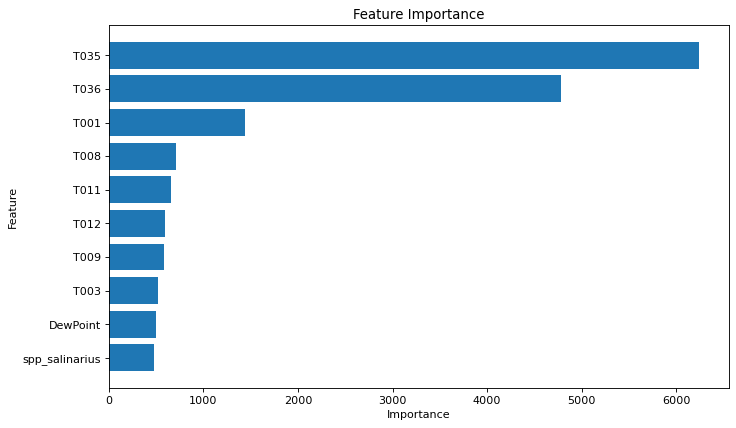

In [12]:
plt.figure(figsize=(10, 6), dpi=80)
plt.barh(df['Feature'], df['Importance'])
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.gca().invert_yaxis();